In [25]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from qadence import *
from qadence.types import BasisSet, ReuploadScaling

In [31]:
def dfdx_equation(x: torch.Tensor, f: torch.Tensor) -> torch.Tensor:
    """Derivative as per the equation."""
    return 4*x**3 + x**2 - 2*x - 0.5

In [40]:
def rk4_solver(f, x0, y0, h, n):
    x = [x0]
    y = [y0]
    for i in range(n):
        k1 = h * f(x[-1], y[-1])
        k2 = h * f(x[-1] + 0.5 * h, y[-1] + 0.5 * k1)
        k3 = h * f(x[-1] + 0.5 * h, y[-1] + 0.5 * k2)
        k4 = h * f(x[-1] + h, y[-1] + k3)
        
        x.append(x[-1] + h)
        y.append(y[-1] + (k1 + 2*k2 + 2*k3 + k4) / 6)
    
    return np.array(x), np.array(y)

In [7]:
def calc_deriv(outputs: torch.Tensor, inputs: torch.Tensor) -> torch.Tensor:
    """Compute a derivative of model that learns f(x), computes df/dx using torch.autograd."""
    grad = torch.autograd.grad(
        outputs=outputs,
        inputs=inputs,
        grad_outputs = torch.ones_like(inputs),
        create_graph = True,
        retain_graph = True,
    )[0]
    return grad

In [37]:
# Mean-squared error as the comparison criterion
criterion = torch.nn.MSELoss()
def loss_fn(model: torch.nn.Module, inputs: torch.Tensor, x_reg: torch.Tensor, reg_weight: float) -> torch.Tensor:
    
    # Equation loss
    model_output = model(inputs) 
    deriv_model = calc_deriv(model_output, inputs)
    deriv_exact = dfdx_equation(inputs,model_output)
    ode_loss = criterion(deriv_model, deriv_exact)

    # Boundary loss, f(0) = 0
    boundary_model = model(torch.tensor([[0.0]]))
    boundary_exact = torch.tensor([[1.0]])
    boundary_loss = criterion(boundary_model, boundary_exact)
    
    reg_model_output = model(x_reg)
    reg_loss = criterion(reg_model_output, f_exact(x_reg))

    return ode_loss + boundary_loss + reg_weight * reg_loss

In [9]:
def regularization_weight(nj, niter, ndrop, delta_j):
    return 1 - np.tanh((nj - ndrop) / (delta_j * niter))

In [34]:
def model_(n_qubits,depth,layers):
    

    # Feature map
    fm1 = feature_map(
        n_qubits = n_qubits,
        param = "x",
        fm_type = BasisSet.CHEBYSHEV,
        reupload_scaling = ReuploadScaling.TOWER,
    )
    fm = chain()
    for i in range(layers):
        fm = chain(fm,fm1)

    # Ansatz
    ansatz = hea(n_qubits = n_qubits, depth = depth)

    # Observable
    observable = ising_hamiltonian(n_qubits=n_qubits)#add(Z(i) for i in range(n_qubits))

    circuit = QuantumCircuit(n_qubits, chain(fm, ansatz))
    Model = QNN(circuit = circuit, observable = observable, inputs = ["x"])
    
    return Model

In [33]:
def main(n_qubits,n_epochs,n_points,depth,layers,learning_rate):
    xmin = 0.0
    xmax = 0.9
    min_loss = float('inf')

    model = model_(n_qubits,depth,layers)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    max_grad_norm = 1.0  # Gradient clipping value

    x_reg = torch.linspace(xmin, xmax, steps=20).unsqueeze(1)

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Training data. We unsqueeze essentially making each batch have a single x value.
        x_train = (xmin + (xmax-xmin)*torch.rand(n_points, requires_grad = True)).unsqueeze(1)
    
        reg_weight = regularization_weight(epoch, n_epochs, ndrop=100, delta_j=0.1)
    
        loss = loss_fn(model, x_train, x_reg, reg_weight)
    
        loss.backward()
    
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
    
        optimizer.step()
    
        if loss.item() < min_loss:
            min_loss = loss.item()
            best_model_state = model.state_dict()
    
        if loss.item() <= 0.001:
            break

    # After training, load the best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    return model,min_loss

In [35]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

space = {
    'depth': hp.quniform('depth', 3, 15, 3),
    'layers': hp.quniform('layers', 1, 5, 1),
    'learning_rate': hp.loguniform('learning_rate',  np.log(0.0001), np.log(0.1))
}

n_epochs = 250
n_points = 20
n_qubits = 6

# Define the objective function
def objective(params):
    # Convert hyperparameters to integer where necessary
    params['depth'] = int(params['depth'])
    params['layers'] = int(params['layers'])
    params['learning_rate'] = float(params['learning_rate'])

    # Call the main function with the current hyperparameters
    model, loss = main(n_qubits, n_epochs, n_points, 
                       params['depth'], params['layers'], params['learning_rate'])
    
    # Return the loss
    return {'loss': loss, 'status': STATUS_OK}

# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

# Print the best hyperparameters
print("Best hyperparameters:", best)

100%|██| 100/100 [1:45:47<00:00, 63.48s/trial, best loss: 0.0009406460908838697]
Best hyperparameters: {'depth': 12.0, 'layers': 1.0, 'learning_rate': 0.0010903418744105688}


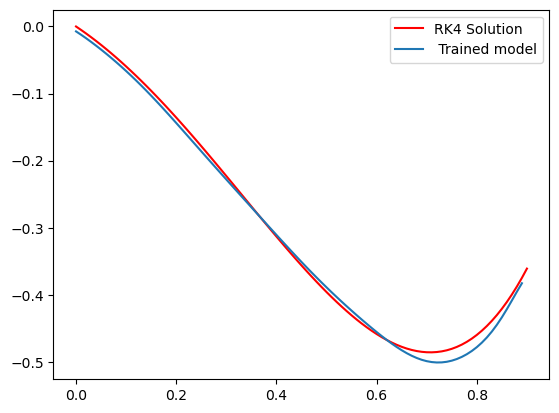

In [43]:
xmin = 0
xmax = 0.9
x_test = torch.arange(xmin, xmax, step = 0.01).unsqueeze(1)
result_exact = f_exact(x_test).flatten()

best_model,_ = main(n_qubits, n_epochs, n_points, depth=int(best['depth']), layers=int(best['layers']), learning_rate=best['learning_rate'])

x_rk4, y_rk4 = rk4_solver(dfdx_equation, 0.0, 0, 0.01, 90)
result_model = best_model(x_test).flatten().detach()

plt.plot(x_rk4, y_rk4, label='RK4 Solution', color='red')
plt.plot(x_test, result_model, label = " Trained model")
plt.legend()